In [6]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from PIL import Image, ImageOps
import cv2
import numpy as np
from matplotlib import pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,5)#1:灰度图片通道，10：输出通道，5：Kernel
        self.conv2 = nn.Conv2d(10,20,3)#1:输入通道，20：输出通道，3：Kernel
        self.fc1 = nn.Linear(20*10*10,500)#20*10*10:输入通道，500：输出通道
        self.fc2 = nn.Linear(500,10)#500:输入通道，10：输出通道
    
    def forward(self,x):
        input_size = x.size(0)#batch_size 
        x = self.conv1(x)#输入：batch*1*28*28，输出：batch*10*24*24  (24 = 28-5+1，经过卷积核运算)
        x = F.relu(x)#激活函数,输出大小保持不变
        x = F.max_pool2d(x,2,2)# 最大池化层（寻找出最大的特征，过滤器为2*2，步长为2） 输入：batch*10*24*24 输出batch*10*12*12
        
        x = self.conv2(x)# 输入：batch*10*12*12,输出：batch*20*10*10  (10=12-3+1)
        x = F.relu(x)
        
        x = x.view(input_size,-1)#各自拉平，-1：自动计算维度 ，20*10*10=2000
        
        x = self.fc1(x)#输入：batch*2000 输出：batch*500
        x = F.relu(x) 
        
        x = self.fc2(x)#输入：batch*500，输出：batch*10
        
        output = F.log_softmax(x,dim=1)#计算分类后，每个数字的概率值
        
        return output


In [7]:
def predict(img, model, DEVICE):
    transform = transforms.Compose([
        transforms.Resize((22,22)),
        transforms.Lambda(lambda img: ImageOps.expand(img, border=3, fill=0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
        ])
    img = transform(img).to(DEVICE)
    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1,keepdim=True)
    return pred.item()

In [8]:
from PIL import Image
#图像裁剪
def image_process(img):
    digit_images = []
    
    #获取二值图像
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)
    
    #获取轮廓并裁剪
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        digit_img = binary[y:y+h, x:x+w]
        
        #将数字放到中间
        height, width = digit_img.shape
        size = max(height, width)
        padded_img = np.zeros((size, size), dtype=np.uint8)
        padded_img[(size - height) // 2:(size - height) // 2 + height, (size - width) // 2:(size - width) // 2 + width] = digit_img
        digit_img = padded_img
        
        #转为PIL对象
        digit_img = Image.fromarray(digit_img)
        digit_img = digit_img.convert('L')
        
        digit_images.append(digit_img)
        
    for pic in digit_images:
        plt.imshow(pic)
        plt.show()

    return digit_images

In [9]:

def predict_sequence(img, model, DEVICE):
    digit_images = image_process(img)
    predictions = []
    for digit_img in digit_images:
        pred = predict(digit_img, model, DEVICE)
        predictions.append(str(pred))
    return predictions

The ID is: 272


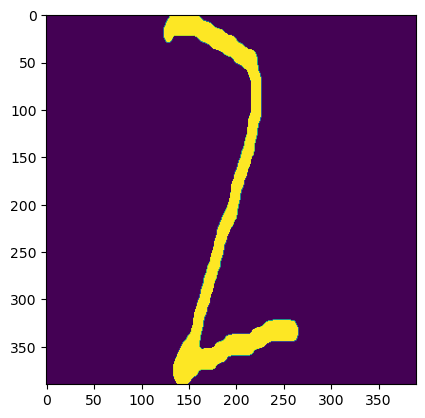

In [10]:
img = cv2.imread("digits.png")
img = cv2.resize(img, (800, 400))
model = NetV1().to(DEVICE)
model.load_state_dict(torch.load("mnist_model"))

res = predict_sequence(img, model, DEVICE)
print("The ID is:",res)